In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO, UNO, TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
from models import UNO_reparam, TFNO_reparam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Subsampling rate
ntrain = 1500
ntest = 150
batch_size = 32

t1 = 5
t2 = 7
data = np.load("data/ks_2d_data.npy").astype(np.float32)

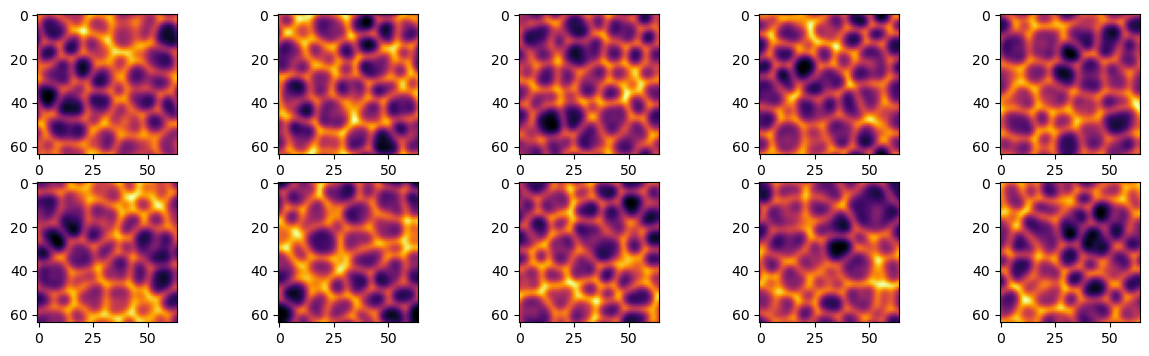

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(2, 5, figsize = (15,4))
index = 0
for i, sample in enumerate(n_samples):
    axs[0,i].imshow(data[sample, t1], cmap = "inferno")
    axs[1,i].imshow(data[sample, t2], cmap = "inferno")

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
x = np.linspace(0, grid_range, size_x)
y = np.linspace(0, grid_range, size_x)
gridx = np.stack(np.meshgrid(x, y))
gridx = torch.tensor(gridx).float().reshape(1, 2, size_x, size_x)

x_train = torch.cat((x_train, gridx.repeat([ntrain, 1, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx.repeat([ntest, 1, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [5]:
# Losses and parameters
l2loss = LpLoss(d=2, p=2, L = 50.0)
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = 50.0)
#energy_score = KernelScore(d=2, p=2, type = "lp",  L = 50.0, kernel ="laplace", gamma = 20)

# Training parameters
epochs = 25
learning_rate = 0.0015
dropout_rate = 0.1

# MC dropout

In [6]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [7]:
model = TFNO(n_modes=(16,16), hidden_channels=32, projection_channels=64,in_channels = 3, rank = 0.42, use_mlp = True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 527673 parameters.


In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

/scratch/buelte/anaconda3/envs/neuralop/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch-0, Time-3.3308, Train-MSE-0.8825, Train-L2-0.0294, Test-L2-0.0307
Epoch-1, Time-1.7842, Train-MSE-0.8350, Train-L2-0.0286, Test-L2-0.0307
Epoch-2, Time-1.9251, Train-MSE-0.8315, Train-L2-0.0286, Test-L2-0.0307
Epoch-3, Time-1.9302, Train-MSE-0.8264, Train-L2-0.0285, Test-L2-0.0307
Epoch-4, Time-1.9159, Train-MSE-0.8205, Train-L2-0.0284, Test-L2-0.0305
Epoch-5, Time-1.9130, Train-MSE-0.8037, Train-L2-0.0281, Test-L2-0.0299
Epoch-6, Time-1.9253, Train-MSE-0.7683, Train-L2-0.0275, Test-L2-0.0293
Epoch-7, Time-1.9131, Train-MSE-0.7437, Train-L2-0.0270, Test-L2-0.0290
Epoch-8, Time-1.9035, Train-MSE-0.7313, Train-L2-0.0268, Test-L2-0.0288
Epoch-9, Time-1.9038, Train-MSE-0.7124, Train-L2-0.0264, Test-L2-0.0287
Epoch-10, Time-1.9104, Train-MSE-0.7034, Train-L2-0.0263, Test-L2-0.0284
Epoch-11, Time-1.9047, Train-MSE-0.6860, Train-L2-0.0260, Test-L2-0.0284
Epoch-12, Time-1.8909, Train-MSE-0.6755, Train-L2-0.0258, Test-L2-0.0282
Epoch-13, Time-1.8922, Train-MSE-0.6619, Train-L2-0.0255, Tes

In [10]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=50)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x, size_x), y_test.view(-1, size_x, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.6803531050682068
ES: 38.215248107910156


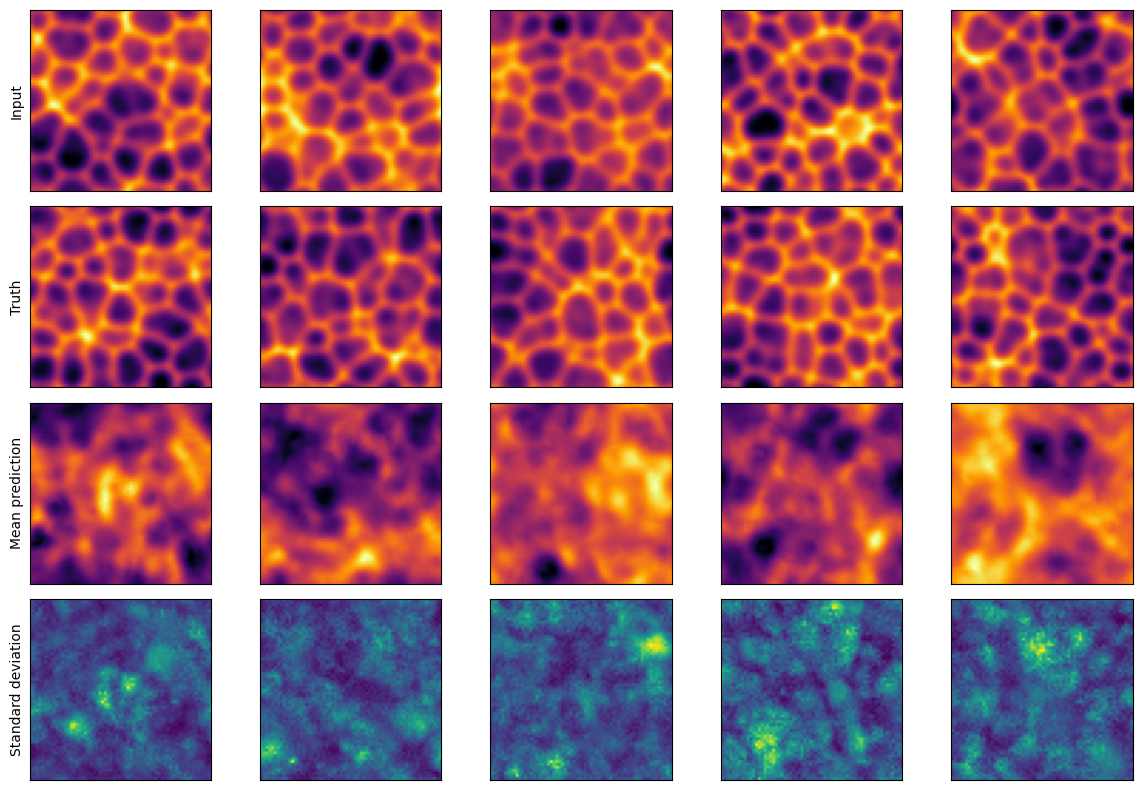

In [11]:
x_test, y_test = test_data

n_samples = np.random.randint(0,ntest,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        axs[0,i].imshow(x_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[1,i].imshow(y_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[2,i].imshow(pred[sample,0].cpu().numpy().mean(axis = -1), cmap = "inferno")
        axs[3,i].imshow(pred[sample,0].cpu().numpy().std(axis = -1), cmap = "viridis")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')

fig.tight_layout()

In [12]:
pred[:,0].cpu().numpy().std(axis = -1).mean()

0.087382406

# PFNO

In [13]:
sample_model = TFNO_reparam(n_modes=(16,16), hidden_channels=32, projection_channels=64, in_channels=3, n_samples = 5, rank = 0.42,
                            use_mlp = True, mlp_dropout=0)

sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [14]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y = sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-12.8675, Train-L2-1.1026, Test-L2-1.0841
Epoch-1, Time-12.8035, Train-L2-1.0106, Test-L2-1.0783
Epoch-2, Time-12.8229, Train-L2-1.0087, Test-L2-1.0708
Epoch-3, Time-12.8521, Train-L2-1.0035, Test-L2-1.0679
Epoch-4, Time-12.8181, Train-L2-0.9933, Test-L2-1.0554
Epoch-5, Time-12.8373, Train-L2-0.9754, Test-L2-1.0337
Epoch-6, Time-12.8594, Train-L2-0.9629, Test-L2-1.0299
Epoch-7, Time-12.8622, Train-L2-0.9589, Test-L2-1.0210
Epoch-8, Time-12.8837, Train-L2-0.9495, Test-L2-1.0159
Epoch-9, Time-12.8648, Train-L2-0.9429, Test-L2-1.0163
Epoch-10, Time-12.8367, Train-L2-0.9349, Test-L2-1.0043
Epoch-11, Time-12.8633, Train-L2-0.9299, Test-L2-0.9994
Epoch-12, Time-12.8391, Train-L2-0.9207, Test-L2-1.0035
Epoch-13, Time-12.8246, Train-L2-0.9175, Test-L2-0.9940
Epoch-14, Time-12.8625, Train-L2-0.9095, Test-L2-0.9941
Epoch-15, Time-12.8630, Train-L2-0.9022, Test-L2-0.9901
Epoch-16, Time-12.8552, Train-L2-0.8950, Test-L2-0.9885
Epoch-17, Time-12.8567, Train-L2-0.8892, Test-L2-0.9860
Ep

In [15]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"]#.to(device)
        y = sample["y"]#.to(device)
        out = sample_model.cpu()(x, n_samples = 50).detach()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x, size_x), y_test.view(-1, size_x, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.7103525996208191
ES: 29.555116653442383


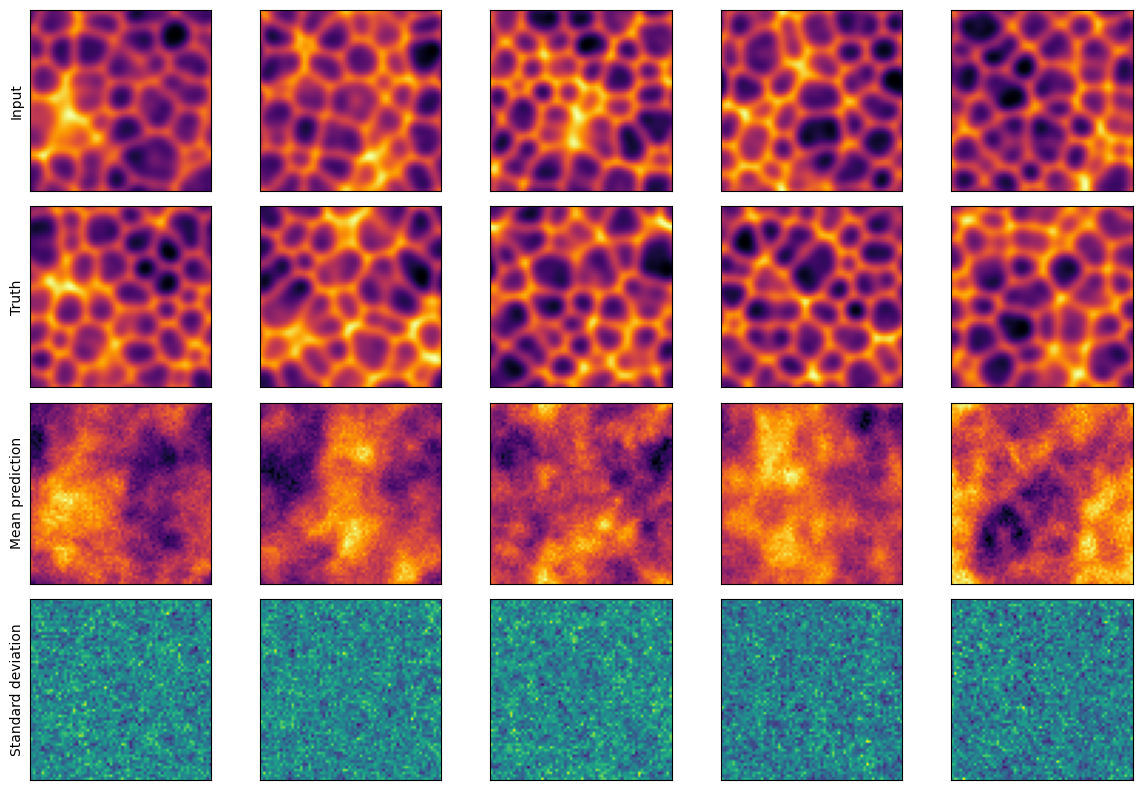

In [16]:
x_test, y_test = test_data
# %%

n_samples = np.random.randint(0,ntest,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        axs[0,i].imshow(x_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[1,i].imshow(y_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[2,i].imshow(pred[sample,0].cpu().numpy().mean(axis = -1), cmap = "inferno")
        axs[3,i].imshow(pred[sample,0].cpu().numpy().std(axis = -1), cmap = "viridis")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')

fig.tight_layout()

In [17]:
pred[:,0].cpu().numpy().std(axis = -1).mean()

0.7636585

In [18]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.6803531050682068
ES-Dropout: 38.215248107910156
MSE: 0.7103525996208191
ES: 29.555116653442383
